In [1]:
import os
import numpy as np
from netCDF4 import Dataset
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

In [71]:

data_dir = '../results/Modis/sst/'
varname = 'sst'
cmin, cmax = 10, 30
# Initialize a dictionary to hold the data for each month.
monthly_data = {month: [] for month in range(1, 13)}
# Assuming these are the coordinates you want to crop to
# lat_min_crop, lat_max_crop = 34.3, 35.7  # Update these values as needed
# lon_min_crop, lon_max_crop = 138.3, 140.23  # Update these values as needed
lat_min_crop, lat_max_crop = 34.5, 35.4
lon_min_crop, lon_max_crop = 138.82, 139.9



In [72]:

# Loop through files and accumulate data
for file_name in os.listdir(data_dir):
    if file_name.endswith('.nc'):
        year, month = int(file_name[1:5]), int(file_name[5:7])
        file_path = os.path.join(data_dir, file_name)
        with Dataset(file_path, 'r') as nc:
            data = np.ma.squeeze(nc[varname][:])
            lat = nc['lat'][:]
            lon = nc['lon'][:]
            
            # Find indices for cropping
            lat_inds = np.where((lat >= lat_min_crop) & (lat <= lat_max_crop))[0]
            lon_inds = np.where((lon >= lon_min_crop) & (lon <= lon_max_crop))[0]
            # Crop data
               # Now add a check to ensure the indices are within the bounds of the array
            if lat_inds.size > 0 and lon_inds.size > 0:
               # Adjust the slicing based on the actual dimensions of sds
               data_cropped = data[lat_inds, :][:, lon_inds]  # This is the updated line for a 2D array
               lat_cropped = lat[lat_inds]
               lon_cropped = lon[lon_inds]
            else:
               print("No data within specified crop bounds.")
            
            # print(np.ma.mean(data_cropped))    
            # sds_cropped = sds[:, lat_inds, :][:, :, lon_inds]  # Assuming sds has a shape of [time, lat, lon]
            lat_cropped = lat[lat_inds]
            lon_cropped = lon[lon_inds]
            # Convert masked values to NaN
            data_cropped = np.where(data_cropped.mask, np.nan, data_cropped)
            
            monthly_data[month].append(data_cropped)



In [20]:
# Compute the average for each month while ignoring NaN values
monthly_averages = {month: np.nanmean(np.stack(data_list), axis=0) for month, data_list in monthly_data.items() if data_list}

print(len(monthly_averages))
for month, data in monthly_averages.items():
    plt.figure()
    extent = [lon_cropped.min(), lon_cropped.max(), lat_cropped.min(), lat_cropped.max()]
    lon_0, lat_0 = (lon_cropped.min() + lon_cropped.max()), (lat_cropped.min() + lat_cropped.max()) / 2
    m = Basemap(llcrnrlon=lon_cropped.min(), llcrnrlat=lat_cropped.min(), 
                    urcrnrlon=lon_cropped.max(), urcrnrlat=lat_cropped.max(), resolution='i', 
                    lon_0=lon_0, lat_0=lat_0, projection='merc')
    
    #  m.drawcoastlines()
    #  m.drawparallels(np.arange(int(np.min(lat)), int(np.max(lat)) + 1, 1), labels=[1,0,0,0])
    #  m.drawmeridians(np.arange(int(np.min(lon)), int(np.max(lon)) + 1, 1), labels=[0,0,0,1])
    if lat.ndim > 1:
      lat = lat[:, 0]
    if lon.ndim > 1:
      lon = lon[0, :]
    
    lon_edges = np.linspace(lon_cropped.min(), lon_cropped.max(), data.shape[1]+1)
    lat_edges = np.linspace(lat_cropped.min(), lat_cropped.max(), data.shape[0]+1)

    lon_mesh, lat_mesh = np.meshgrid(lon_edges, lat_edges)

    x, y = m(lon_mesh, lat_mesh)
    
   #  cs = m.pcolormesh(x, y, data, shading='flat', cmap=plt.cm.jet)
    cs = m.pcolormesh(x, y, data,  cmap=plt.cm.jet, vmin=0, vmax=10)
    plt.colorbar(cs, orientation='vertical', shrink=0.5)
    plt.title(f'Average SST for Month {month:02d}')
    plt.savefig(f'average_sst_{month:02d}.png', dpi=300)
    plt.close()


C:\Users\Robel\AppData\Local\Temp\ipykernel_10708\318029395.py:2: RuntimeWarning: Mean of empty slice
  monthly_averages = {month: np.nanmean(np.stack(data_list), axis=0) for month, data_list in monthly_data.items() if data_list}


12


In [92]:

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plot, colors
# Define your color list in hex
# hex_colors = [
#     '#3500a8', '#0800ba', '#003fd6',
#     '#00aca9', '#77f800', '#ff8800',
#     '#b30000', '#920000', '#880000'
# ]
hex_colors_sst = [
   '#ffffff','#b7f0ae','#21f600','#0000FF','#FDFF92','#FF2700','#d600ff'
]
hex_colors_sst = [
    '#ffffff',  # white
    '#e8f8ff',  # very light blue (cold)
    '#b7f0ae',  # light green
    '#8ae68a',  # intermediate green
    '#21f600',  # bright green (warm)
    '#7bff7b',  # intermediate between green and blue
    '#0000FF',  # blue
    '#7f92ff',  # light blue (getting warmer)
    '#FDFF92',  # light yellow (warm)
    '#FFD700',  # gold
    '#FFA500',  # orange
    '#FF2700',  # red (hot)
    '#e60000',  # deep red (hotter)
    '#d600ff',  # purple (very hot)
    '#a500ff',  # deep purple (even hotter)
]
# hex_colors_sst = [
# "#90EE90", "#2E8B57", "#228B22", "#006400",
#    "#FFFFE0", "#FFD700", "#CC7722", "#DAA520",
#     "#FFE5B4", "#FF7F50", "#FFA500", "#CC5500",
#    "#FFC0CB", "#FF0000", "#DC143C", "#800000"
# ]
hex_colors_sst = [

    "#007ACC",  # Deep Sky Blue
    "#43AA8B",  # Dark Cyan
    "#87CEEB",  # Sky Blue
    "#C2E0F0",  # Light Sky Blue
    "#A0D6E8",  # Pale Blue Green
    "#3FB8A0",  # Sea Green
    "#76C8A3",  # Light Sea Green
    "#00FF00",  # Lime Green
    "#FFFF00",  # Yellow
    "#FFA500",  # Orange
    "#FF8000",  # Dark Orange
    "#FF0000"   # Red
]
# # Convert hex color list to RGB
rgb_colors = [colors.hex2color(color) for color in hex_colors_sst]
# rgb_colors = [ "green",  "yellow","orange","red"]

C:\Users\Robel\AppData\Local\Temp\ipykernel_10708\941932781.py:1: RuntimeWarning: Mean of empty slice
  monthly_averages = {month: np.nanmean(np.stack(data_list), axis=0) for month, data_list in monthly_data.items() if data_list}


12


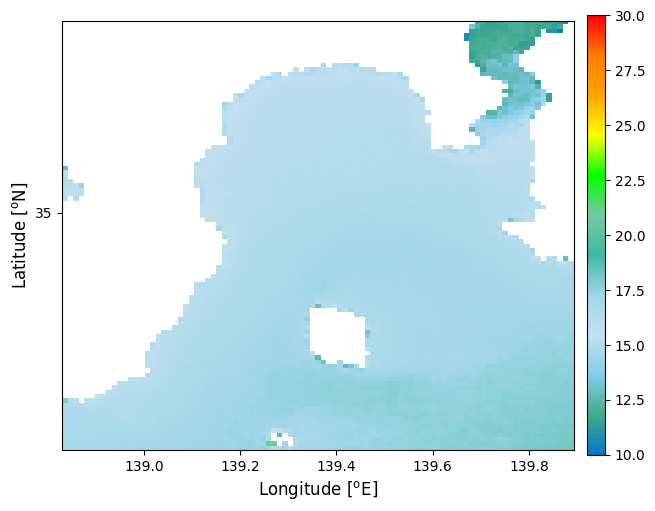

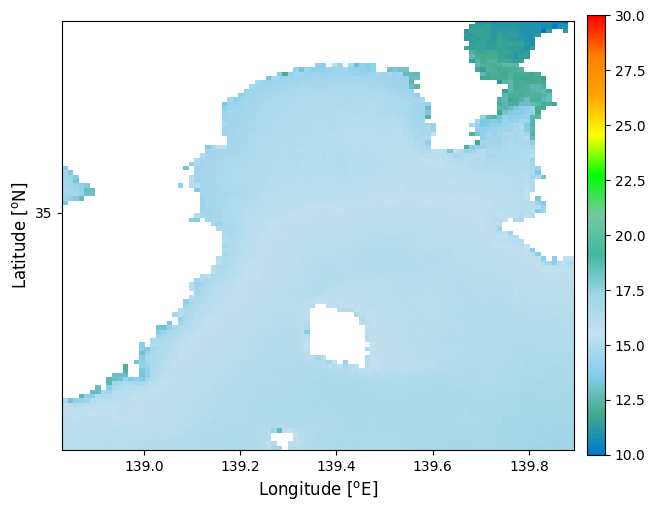

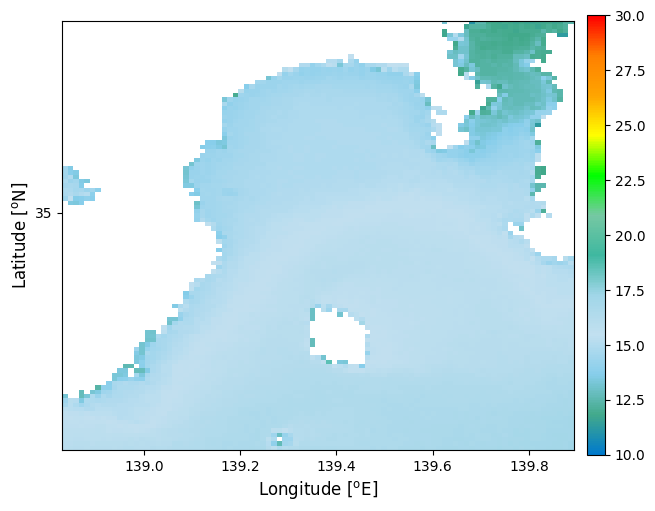

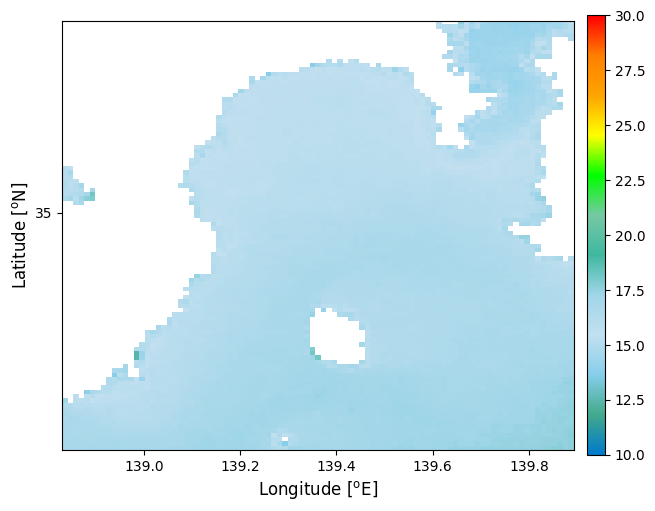

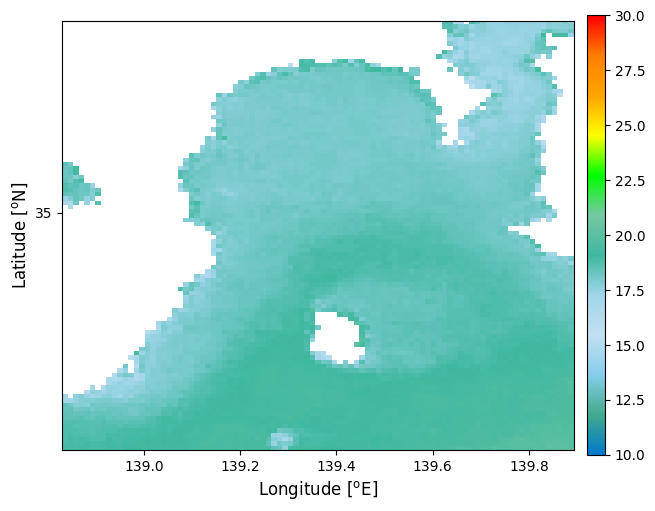

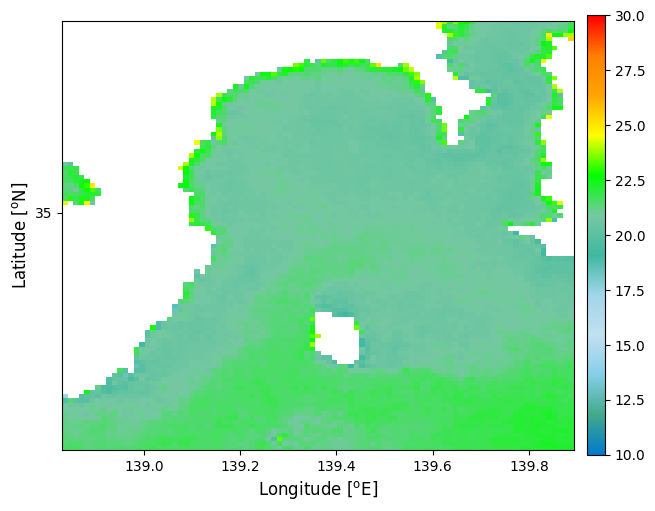

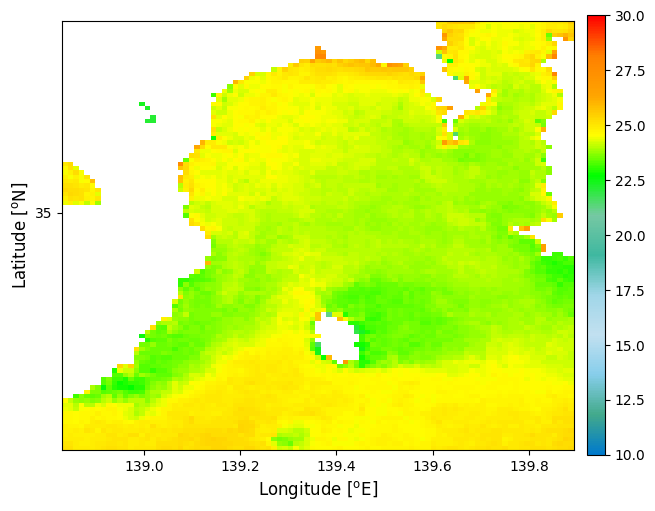

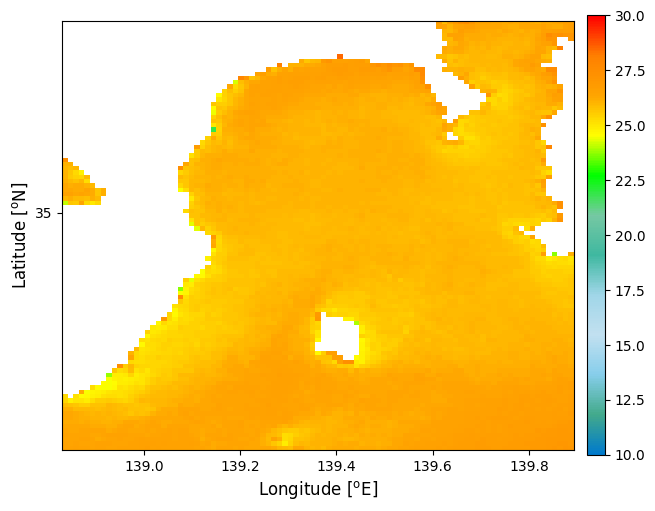

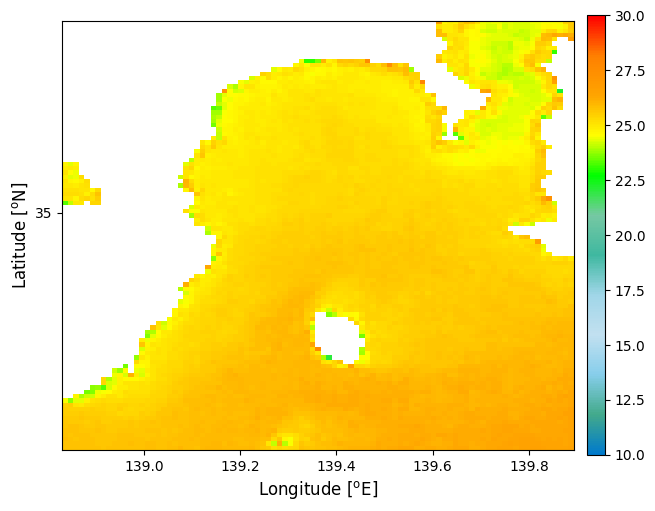

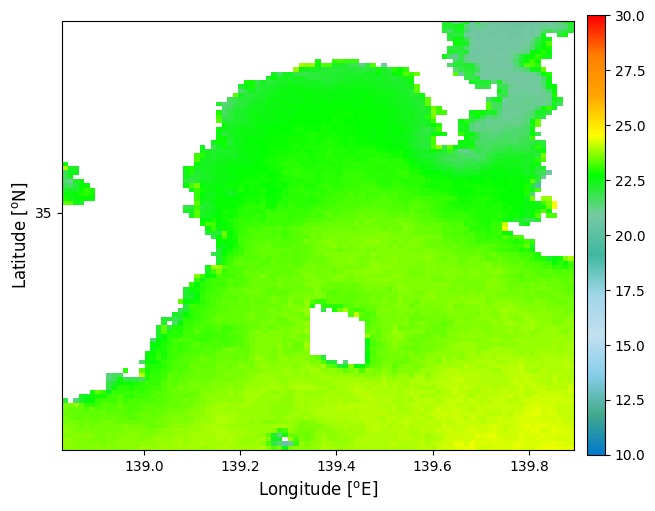

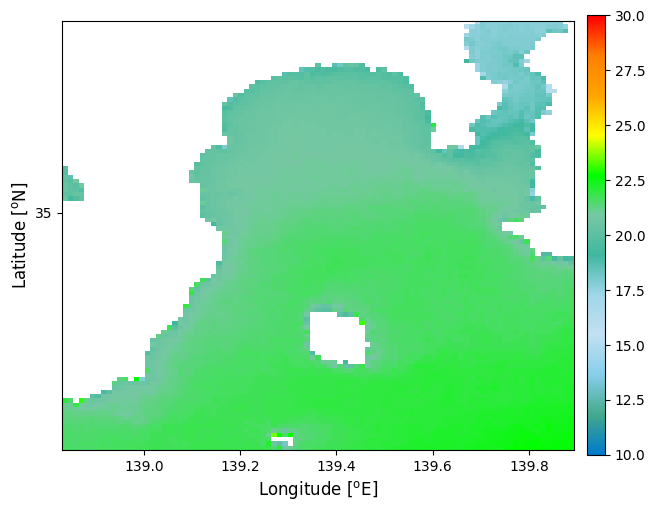

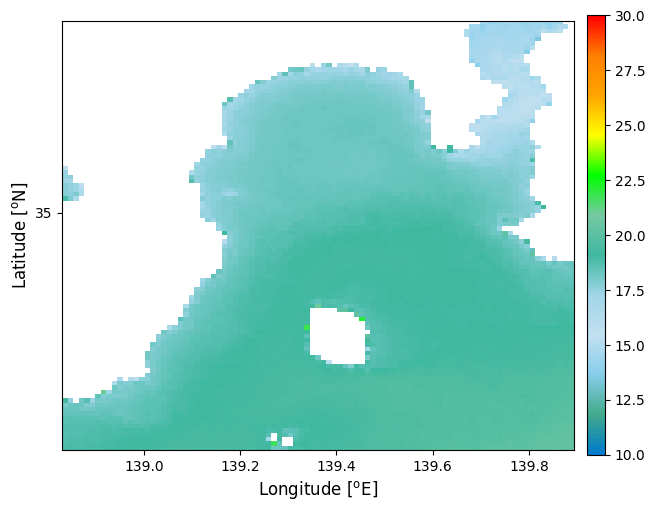

In [93]:
monthly_averages = {month: np.nanmean(np.stack(data_list), axis=0) for month, data_list in monthly_data.items() if data_list}
print(len(monthly_averages))
for month, sds_cropped in monthly_averages.items():    # Visualisation with basemap
    # print("runnign")
    if len(lon_cropped.shape) == 1:
        lon_cropped, lat_cropped = np.meshgrid(lon_cropped, lat_cropped)
    lon_0, lat_0 = (lon_cropped.min() + lon_cropped.max()), (lat_cropped.min() + lat_cropped.max()) / 2
    m = Basemap(llcrnrlon=lon_cropped.min(), llcrnrlat=lat_cropped.min(), 
                        urcrnrlon=lon_cropped.max(), urcrnrlat=lat_cropped.max(), resolution='i', 
                        lon_0=lon_0, lat_0=lat_0, projection='merc')

    # print(sds_cropped)
    # sds_cropped_log = np.ma.masked_less_equal(sds_cropped, 0)  # Mask non-positive values
    # sds_cropped_log = np.ma.log10(sds_cropped_log)  # Apply log10 to the data
    # print(sds_cropped_log)


    # Visualisation without basemap
    # Adjust figsize to change the aspect ratio
    fig, ax = plot.subplots(figsize=(7, 6))  # Adjust the width and height to better suit your data aspect ratio

    # figure bounds
    extent = [lon_cropped.min(), lon_cropped.max(), lat_cropped.min(), lat_cropped.max()]

    # Land mask
    # mask = np.where(~sds_cropped.mask, np.nan, 0)
    ax.imshow(sds_cropped, cmap='gray', vmin=-2, vmax=0, extent=extent)

    # Create a colormap object
    custom_colormap = LinearSegmentedColormap.from_list('custom', rgb_colors)

    # print(sds_cropped_log.max(), sds_cropped_log.min())
    # Data 
    # We no longer use LogNorm here since we've manually applied log10
    # ims = ax.imshow(sds_cropped_log, cmap='jet', extent=extent)
    # ims = ax.imshow(sds_cropped,vmin=cmin, vmax=cmax,   extent=extent)
    ims = ax.imshow(sds_cropped,vmin=cmin, vmax=cmax,  cmap=custom_colormap, extent=extent)

    # # Figure labels
    ax.set_xlabel('Longitude [$^\mathregular{o}$E]', fontsize="12")
    ax.set_ylabel('Latitude [$^\mathregular{o}$N]', fontsize="12")
    ax.set_yticks(range(int(np.ceil(lat_cropped.min())), int(np.ceil(lat_cropped.max())), 1))
    # ax.set_title(time[0].strftime('%b %Y'))

    # # Colourbar
    cbar = fig.colorbar(ims, ax=ax, orientation='vertical', fraction=0.0324, pad=0.025,  aspect=25)
    # cbar.set_label('log10(Chl-a) Conc. mg/m^3', fontsize="12")

    # ticks = [ims.get_clim()[0],0, ims.get_clim()[1]] # This gets the color limit range
    # cbar.set_ticks(ticks)
    # cbar.set_ticklabels([f'{ticks[0]:.2f}', f'{ticks[1]:.2f}', f'{ticks[2]:.2f}']) # Format as desired

    # Small Sagami Bay
    lat_min, lat_max = 35.124, 35.34
    lon_min, lon_max = 139.115, 139.68
    plt.savefig(f'average_sst_{month:02d}.png', dpi=300)
